<!--BOOK_INFORMATION-->
<img align="left" style="width:80px;height:98px;padding-right:20px;" src="https://raw.githubusercontent.com/joe-papa/pytorch-book/main/files/pytorch-book-cover.jpg">

This notebook contains an excerpt from the [PyTorch Pocket Reference](http://pytorchbook.com) book by [Joe Papa](http://joepapa.ai); content is available [on GitHub](https://github.com/joe-papa/pytorch-book).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joe-papa/pytorch-book/blob/main/03_Deep_Learning_Development_with_PyTorch.ipynb)

# Chapter 3 - Modified to show feature extraction

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

print(torch.__version__)
# out: 1.7.0+cu101

print(torchvision.__version__)
# out: 0.8.1+cu101


2.0.1+cu117
0.15.2+cu117


## Data with Transforms

In [2]:
from torchvision import transforms
import torchvision
from torchvision.datasets import CIFAR10


train_transforms = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

train_data = CIFAR10(root="./train/",
                    train=True, 
                    download=True,
                    transform=train_transforms)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


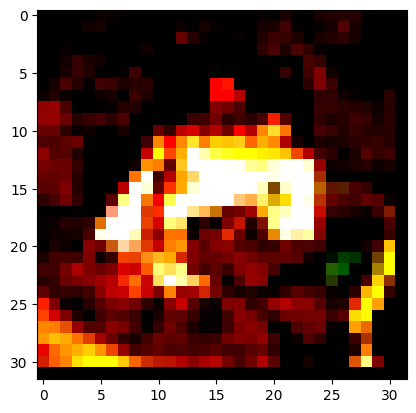

In [3]:
data,_ = train_data[0]
plt.imshow(data.permute(1, 2, 0))

In [4]:
data.shape

torch.Size([3, 32, 32])

In [5]:
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

test_data = torchvision.datasets.CIFAR10(
      root="./test/", 
      train=False, 
      transform=test_transforms)

## Data Batching

In [6]:
trainloader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=16, 
                    shuffle=True)

In [7]:
testloader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=16, 
                    shuffle=False)

## Model Design



In [8]:
from torch import nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # <1>
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet5().to(device=device)

## Submodel

In [9]:
layers = list(model.children())[:-3]

In [10]:
print(layers)

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]


In [11]:
feat_ext = nn.Sequential(*layers)


In [12]:
print(feat_ext)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
)


In [13]:
feat_ext = feat_ext.to(device=device)

In [14]:
test_feat, test_label= next(iter(testloader))

In [15]:
test_feat = test_feat.to(device=device)

In [16]:
test_feat.shape

torch.Size([16, 3, 32, 32])

### out_feat are the features extracted before the model was trained

In [17]:
out_feat = feat_ext(test_feat)

In [18]:
out_feat.shape

torch.Size([16, 16, 24, 24])

In [19]:
for i in range(out_feat.shape[1]):
    im = transforms.ToPILImage()(out_feat[0,i,:,:]).convert("L")
    display(im)


## Validation & Testing

### Splitting Training Dataset into Training & Validation Datasets

In [20]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      train_data, 
                      [40000, 10000])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

2500
625


### Training Loop with Validation

In [21]:
from torch import optim
from torch import nn

model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

In [22]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(torch.log(outputs), labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))

# out: (results may vary and take a few minutes)
# Epoch: 0 Train Loss: 1.9876076080799103 Val Loss: 1.7407869798660278
# Epoch: 1 Train Loss: 1.6497538920879364 Val Loss: 1.5870195521354675
# Epoch: 2 Train Loss: 1.5117236899614335 Val Loss: 1.4355393668174743
# Epoch: 3 Train Loss: 1.408525426363945 Val Loss: 1.3614536597251892
# Epoch: 4 Train Loss: 1.3395055189609528 Val Loss: 1.2934591544151306
# Epoch: 5 Train Loss: 1.290560259628296 Val Loss: 1.245048282814026
# Epoch: 6 Train Loss: 1.2592685657382012 Val Loss: 1.2859896109580993
# Epoch: 7 Train Loss: 1.235161985707283 Val Loss: 1.2538409409046174
# Epoch: 8 Train Loss: 1.2070518508672714 Val Loss: 1.2157000193595886
# Epoch: 9 Train Loss: 1.189215132522583 Val Loss: 1.1833322570323943

/tmp/ipykernel_380740/523642830.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Epoch: 0 Train Loss: 1.980034641456604 Val Loss: 2.170271786117554
Epoch: 1 Train Loss: 1.6501046507835389 Val Loss: 2.124664950180054
Epoch: 2 Train Loss: 1.523638024687767 Val Loss: 2.091059129905701
Epoch: 3 Train Loss: 1.4414931705236436 Val Loss: 2.0704110635757447
Epoch: 4 Train Loss: 1.3852062034845352 Val Loss: 2.046033783531189
Epoch: 5 Train Loss: 1.3348623636960983 Val Loss: 2.0206635173797607
Epoch: 6 Train Loss: 1.303551110804081 Val Loss: 2.0334553716659545
Epoch: 7 Train Loss: 1.2655839226007461 Val Loss: 2.0089780002593995
Epoch: 8 Train Loss: 1.2399117582917214 Val Loss: 1.9901987798690797
Epoch: 9 Train Loss: 1.2247228411436082 Val Loss: 1.9953125661849975


### Testing Loop

In [23]:
num_correct = 0.0
for x_test_batch, y_test_batch in testloader:
  model.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted == y_test_batch).float().sum()
  
accuracy = num_correct/(len(testloader)*testloader.batch_size) 

print(len(testloader), testloader.batch_size)
# out: 625 16

print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

/tmp/ipykernel_380740/523642830.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


625 16
Test Accuracy: 0.6040999889373779


# out_feat1 are the features extracted after the model was trained

### test features again

In [24]:
layers1 = list(model.children())[:-3]
feat_ext1 = nn.Sequential(*layers1)
feat_ext1 = feat_ext1.to(device=device)

In [25]:
out_feat1 = feat_ext1(test_feat)
for i in range(out_feat1.shape[1]):
    im = transforms.ToPILImage()(out_feat1[0,i,:,:]).convert("L")
    display(im)

In [ ]:
out_feat1.shape

In [26]:
x= out_feat1[0]
x = x.view(-1, int(x.nelement()))
#im = transforms.ToPILImage()(x).convert("L")
#display(im)

In [27]:
x.shape

torch.Size([1, 9216])

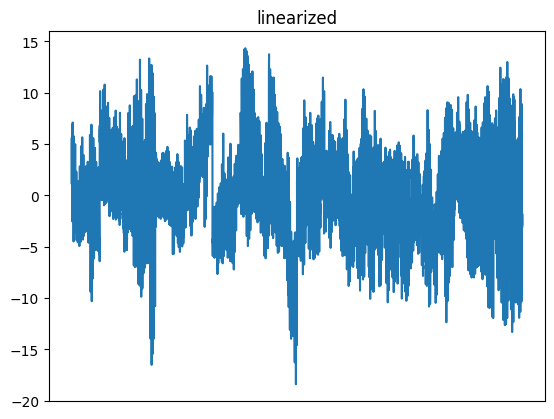

In [28]:
import numpy as np
figure1 = plt.figure(1) 
y = x.cpu().detach().numpy()
plt.plot(np.arange(0,y.shape[1]),y.squeeze())
plt.xticks([])
#plt.yticks([])
plt.title('linearized')
figure1.savefig(f'cifar10feat.png')
#plt.close('all')

In [29]:
test_label[0]

tensor(3)

In [30]:
test_label = test_label.cpu().detach().numpy()

In [31]:
test_label

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])

Text(0.5, 1.0, 'linearized')

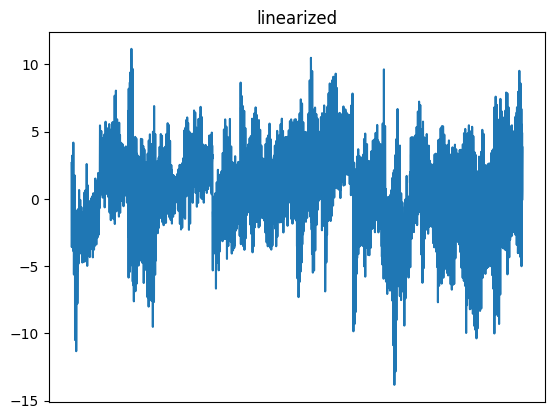

In [32]:
#figure2 = plt.figure(1) 
x= out_feat1[8]
x = x.view(-1, int(x.nelement()))
y = x.cpu().detach().numpy()
plt.plot(np.arange(0,y.shape[1]),y.squeeze())
plt.xticks([])
#plt.yticks([])
plt.title('linearized')
#figure2.savefig(f'cifar10feat.png')

Text(0.5, 1.0, 'linearized')

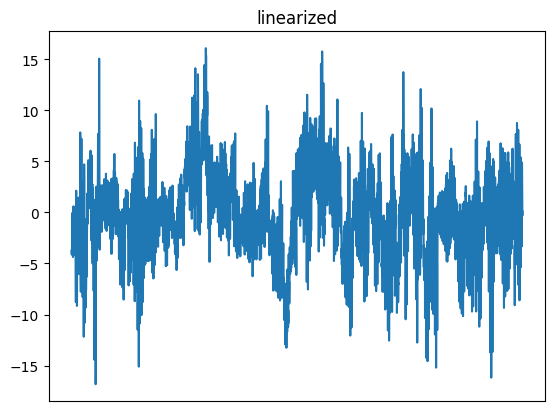

In [33]:
#figure2 = plt.figure(1) 
x= out_feat1[1]
x = x.view(-1, int(x.nelement()))
y = x.cpu().detach().numpy()
plt.plot(np.arange(0,y.shape[1]),y.squeeze())
plt.xticks([])
#plt.yticks([])
plt.title('linearized')
#figure2.savefig(f'cifar10feat.png')